In [ ]:
import sys
import os

# Get the path to the directory above the current one
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

# Double-check your current directory
print(f"Current Working Directory: {os.getcwd()}")
print(f"Project root added to path. You can now import.")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from PIL import Image, ImageOps
import copy
import pandas as pd

In [3]:
# Adjust the config values based on your preference
config = {"n_classes": 21,
          "background_weight": 0.1,
          "lr_rate": 0.001,
          "batch_size": 16,
          "num_workers": 2,
          "resolution": 256,
          "sch_step_size": 15,
          "sch_gamma": 0.1}

In [ ]:
! pip install urllib3

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

print("Path to dataset files:", path)

In [ ]:
# ALL THE PATHS IN THIS NOTEBOOK ARE PUT WITH AN ASSUMPTION THAT YOU ARE WORKING IN GOOGLE COLAB
# CHANGE THE PATHS TO YOUR LOCAL PATHS IF YOU ARE RUNNING THIS NOTEBOOK IN LOCAL ENVIRONMENT
import os

# Define source (Read-only) and target (Writable wrapper)
#    Note: We need to point to the actual VOCdevkit folder inside the input
input_root = '/kaggle/input/pascal-voc-2012-dataset'
target_root = '/content/VOCdevkit/VOC2012'

# Create the destination directory structure (but not the final folder)
os.makedirs('/content/VOCdevkit', exist_ok=True)

# Create the Symlink
#    This creates a "ghost" folder at target_root that points to input_root
if not os.path.exists(target_root):
    print(f"Creating symlink: {target_root} -> {input_root}")
    os.symlink(input_root, target_root)
    print("Success! (No copying required)")
else:
    print("Symlink already exists.")

# Verify it works
print("\nVerifying structure...")
!ls -F /content/VOCdevkit/

In [ ]:
import shutil
import os

# The path you got from the download
cached_path = '/root/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1'
target_path = '/content/VOCdevkit'

# Check if we already moved it to avoid errors
if not os.path.exists(target_path):
    print(f"Moving data from {cached_path} to {target_path}...")
    # We use move because it's instant (metadata change only)
    shutil.move(cached_path, target_path)
    print("Move complete!")
else:
    print("Data is already in /content/VOCdevkit")


print("\nDirectory Structure:")
!find /content/VOCdevkit -maxdepth 2 -type d

If you encounter a `FileNotFoundError`, it is likely due to a symlink failure.

**Symptom**: There is only a single `VOC2012` file inside the VOCdevkit directory instead of a folder.

**Solution**: Delete the created `VOCdevkit` and directory and the `VOC2012` file in it. Skip the symlink cell entirely and run the Kaggle Direct Download cell instead. Note that in this case, the data root path will not have `VOC2012` before `VOC2012_train_val` directories.


In [ ]:
# NOTE: This utility is consistent with V1 to V4 to maintain a controlled experimental environment
from core.data_engine import VOCDataEngine # Handles data loading and DataLoader creation automatically

# One call to prepare the entire data pipeline
engine = VOCDataEngine(root_path='/content/VOCdevkit/VOC2012/VOC2012_train_val/VOC2012_train_val', batch_size=config["batch_size"], num_workers=config["num_workers"], resolution=config["resolution"])
# or "/content/VOCdevkit/VOC2012_train_val/VOC2012_train_val" if the solution against "FileNotFoundError" is implemented
train_loader, val_loader = engine.get_loaders()

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
class BaseSegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_iou': [], 'val_iou': []
        }
        self.best_iou = 0.0

    def update_history(self, train_loss, val_loss, train_iou, val_iou):
        self.history['train_loss'].append(train_loss.item())
        self.history['val_loss'].append(val_loss.item())
        self.history['train_iou'].append(train_iou.item())
        self.history['val_iou'].append(val_iou.item())

    def save_checkpoint(self, path, epoch, iou):
        if iou > self.best_iou:
            self.best_iou = iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': self.state_dict(),
                'history': self.history,
                'best_iou': self.best_iou
            }, path)
            print(f"--- Best Model Saved (mIoU: {iou:.4f}) ---")

In [24]:
class UnetDown(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    model = [
        nn.BatchNorm2d(input_size),
        nn.ELU(),
        nn.Conv2d(input_size, output_size, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(output_size),
        nn.ELU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(output_size, output_size, kernel_size=3, stride=1, padding=1)
    ]

    self.model = nn.Sequential(*model)

  def forward(self, x):
    return self.model(x)

class UnetUp(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()

    model = [
        nn.BatchNorm2d(input_size),
        nn.ELU(),
        nn.Conv2d(input_size, output_size, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(output_size),
        nn.ELU(),
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(output_size, output_size, kernel_size=3, stride=1, padding=1)
    ]

    self.model = nn.Sequential(*model)

  def forward(self, x):
    return self.model(x)

class UnetV1(BaseSegmentationModel):
  def __init__(self, channels_in, channels_out=2):
    super().__init__()

    self.conv_in = nn.Conv2d(channels_in, 64,
                              kernel_size=3, stride=1, padding=1) # H X W --> H X W

    self.down1 = UnetDown(64, 64) # H X W --> H/2 X W/2
    self.down2 = UnetDown(64, 128) # H/2 X W/2 --> H/4 X W/4
    self.down3 = UnetDown(128, 128) # H/4 X W/4 --> H/8 X W/8
    self.down4 = UnetDown(128, 256) # H/8 X W/8 --> H/16 X W/16

    self.up1 = UnetUp(256, 128) # H/16 X W/16 --> H/8 X W/8
    self.up2 = UnetUp(128 *2, 128) # H/8 X W/8 --> H/4 X W/4
    self.up3 = UnetUp(128 *2, 64) # H/4 X W/4 --> H/2 X W/2
    self.up4 = UnetUp(64 *2, 64) # H/2 X W/2 --> H X W

    self.conv_out = nn.Conv2d(64 * 2, channels_out,
                              kernel_size=3, stride=1, padding=1) # H X W --> H X W

  def forward(self, x):
    # ---- ENCODER PATH ----
    x0 = self.conv_in(x) # 16 x H x W

    x1 = self.down1(x0) # 32 x H/2 x W/2
    x2 = self.down2(x1) # 64 x H/4 x W/4
    x3 = self.down3(x2) # 64 x H/8 x W/8
    x4 = self.down4(x3) # 128 x H/16 x W/16

    # --- DECODER PATH ---
    x5 = self.up1(x4) # 64 x H/8 x W/8

    x5_ = torch.cat((x5, x3), 1) # 128 x H/8 x W/8
    x6 = self.up2(x5_) # 32 x H/4 x W/4

    x6_ = torch.cat((x6, x2), 1) # 64 x H/4 x H/4
    x7 = self.up3(x6_) # 16 x H/2 x W/2

    x7_ = torch.cat((x7, x1), 1) # 64 x H/2 x W/2
    x8 = self.up4(x7_) # 16 x H x W

    x8_ = F.elu(torch.cat((x8, x0), 1)) # 32 x H x W
    return self.conv_out(x8_) # 2 x H x W

In [25]:
unetv1 = UnetV1(channels_in=3, channels_out=config["n_classes"])
device = "cuda" if torch.cuda.is_available() else "cpu"
unetv1 = unetv1.to(device)

In [27]:
from core.accuracy import MulticlassIOU

class_weights = torch.ones(config["n_classes"]).to(device)

class_weights[0] = config["background_weight"]

# Define loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)

# Define optimizer and scheduler
optimizer = torch.optim.Adam([
    dict(params=unetv1.parameters(), lr=config["lr_rate"]),
])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config["sch_step_size"], gamma=config["sch_gamma"])

def iou_fn(y_true, y_pred):
    multiclassIOU = MulticlassIOU(num_classes=21)
    iou_score = multiclassIOU.forward(y_pred, y_true)
    return iou_score

In [ ]:
# NOTE: This utility is consistent with V1 to V4 to maintain a controlled experimental environment
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from diagnostics.model_inspector import ModelInspector

# Attach Inspectors
inspector = ModelInspector(unetv1)
inspector.register_hooks()

print("--- STARTING DIAGNOSTIC RUN ---")

unetv1.train()

epochs = 5

for epoch in range(epochs):
  for batch, (X, y) in enumerate(train_loader):
      if epoch == 4 and batch == 0:
          X, y = X.to(device), y.to(device)

          # Forward Pass (Triggers Forward Hooks)
          print(f"\nProcessing Batch {batch}...")
          y_pred = unetv1(X)

          # Calculate Loss
          loss_ce = loss_fn(y_pred, y)
          total_loss = loss_ce

          # Backward Pass (Triggers Backward Hooks)
          optimizer.zero_grad()
          total_loss.backward()

          # We print the report immediately after the first backward pass and stop the process
          inspector.print_report()

          print(f"Diagnosis complete for Batch {batch}. Stopping.")

# Clean up hooks so they don't interfere with future runs
inspector.clear_hooks()

In [29]:
from timeit import default_timer as timer

def print_train_time(start:float,
                     end: float,
                     device: torch.device=None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [30]:
unetv1 = UnetV1(channels_in=3, channels_out=config["n_classes"])
device = "cuda" if torch.cuda.is_available() else "cpu"
unetv1 = unetv1.to(device)

In [33]:
class_weights = torch.ones(config["n_classes"]).to(device)

class_weights[0] = config["background_weight"]

# Define loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)

# Define optimizer and scheduler
optimizer = torch.optim.Adam([
    dict(params=unetv1.parameters(), lr=config["lr_rate"]),
])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config["sch_step_size"], gamma=config["sch_gamma"])

def iou_fn(y_true, y_pred):
    multiclassIOU = MulticlassIOU(num_classes=21)
    iou_score = multiclassIOU.forward(y_pred, y_true)
    return iou_score

In [ ]:
# UTILITY: Re-imports local modules to reflect code changes without a kernel restart.

import sys
import importlib
import core.data_engine

# Force a reload of the specific module
importlib.reload(core.data_engine)

# Re-import the classes to the global namespace
from core.training import Training, EarlyStopping

print("Memory Purged. StaticMethods should be active now.")

If you come across `
AssertionError: No inf checks were recorded for this optimizer.` error when running the training code, just restart optimizer after the model initiation. This error occurs because PyTorch requires model and optimizer be on the same device in order to do AMP.

In [ ]:
torch.manual_seed(42)

from core.training import Training, EarlyStopping

training = Training()

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Initialize early stopping
early_stopper = EarlyStopping(patience=7, min_delta=0.01)

# Set epochs
epochs = 50

# Create an optimizeation and evaluation loop using train_step() and valid_step()
for epoch in tqdm(range(epochs)):
  input_x, label_x = next(iter(train_loader))
  input_y, label_y = next(iter(val_loader))
  t_loss, t_iou = T=training.train_step(model=unetv1,
             data_loader=train_loader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=iou_fn,
             device=device)
  v_loss, v_iou = training.valid_step(model=unetv1,
            data_loader=val_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=iou_fn,
            device=device)

  unetv1.update_history(t_loss, v_loss, t_iou, v_iou)

  # Check Early Stopping
  early_stopper(v_loss)
  if early_stopper.early_stop:
      unetv1.save_checkpoint("best_unet_v1.pth", epoch, v_iou)
      print(f"Early stopping at epoch {epoch}. Model is no longer improving.")
      break

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

In [36]:
import os
import matplotlib.pyplot as plt

def save_evolution_gallery(data, target, predictions, titles, save_dir="inference_results", filename="sample_1.png", num_classes=21):
    """
    Creates the directory and saves the side-by-side evolution plot.
    """
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    num_plots = 2 + len(predictions)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
    cmap = plt.get_cmap('tab20', num_classes)

    # Original Image (Squeezing and permuting for [H, W, C])
    img = data[0].permute(1, 2, 0).cpu().numpy()
    # If normalized, denormalize here (e.g., img * std + mean)
    axes[0].imshow(img)
    axes[0].set_title("Original Image")

    # Ground Truth
    axes[1].imshow(target[0].cpu(), cmap=cmap, vmin=0, vmax=num_classes-1)
    axes[1].set_title("Ground Truth")

    # Model Predictions
    for i, pred in enumerate(predictions):
        # Handle if pred is raw logits (B, C, H, W) or already argmaxed (B, H, W)
        if pred.ndim == 4:
            mask = pred[0].argmax(0).cpu().numpy()
        else:
            mask = pred[0].cpu().numpy()

        axes[i+2].imshow(mask, cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[i+2].set_title(titles[i])

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()

    # Save the figure
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close(fig)

    return save_path

In [ ]:
checkpoint = torch.load('best_unet_v1.pth', weights_only=True)
unetv1.load_state_dict(checkpoint['model_state_dict'])
unetv1.eval()

In [38]:
valid_iter = iter(val_loader)

In [ ]:
# UTILITY: Take batch from validation and save results in a separate directory to inspect them later
# Get one batch from validation
data, target = next(valid_iter)
unetv1.eval()
output = unetv1(data.to(device))
pred = output.argmax(dim=1) # Convert probabilities to class labels

n_images = 50

for n in range(n_images):
  save_evolution_gallery(data, target, [pred], ["UnetV1"], save_dir="unetv1_predictions", filename=f"unetv1_pred_{n}.png")

In [ ]:
import shutil

# This will create 'inference_results.zip' from the folder 'inference_results', something directly downloadable
shutil.make_archive(base_name='unetv1_predictions', format='zip', root_dir='unetv1_predictions')

print("Archive created successfully.")

Archive created successfully.


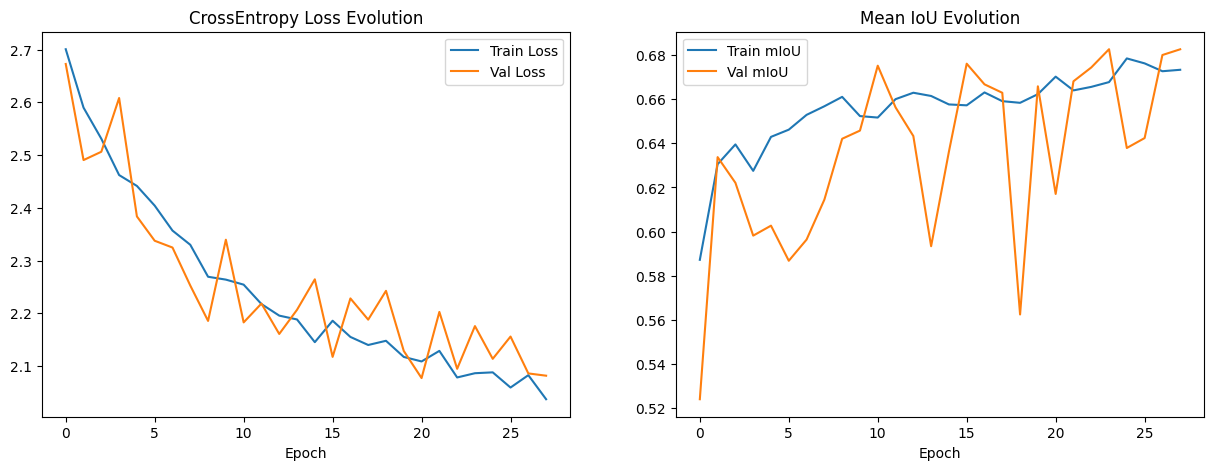

In [ ]:
def plot_metrics(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss Plot
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_title('CrossEntropy Loss Evolution')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    # IoU Plot
    axes[1].plot(history['train_iou'], label='Train mIoU')
    axes[1].plot(history['val_iou'], label='Val mIoU')
    axes[1].set_title('Mean IoU Evolution')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()

    plt.show()

plot_metrics(unetv1.history)